In [78]:
%load_ext autoreload
%autoreload 2

import sys
if '..' not in sys.path:
    sys.path.append('..')
from notebooks.results import load_results, classification, clusterization, to_latex_table, GremDataFrame, include_pivot_index, groups_to_latex_table, VectorInfo, vector_data_iter, dataset_iter, DatasetInfo
import re
import pandas as pd
from qwlist import Lazy, QList
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
GREMVECS = ['BigramMorphTagVectorizer100', 'BigramMorphTagVectorizer370', 'FullMorphTagVectorizer', 'MorphTagVectorizer', 'StyloMetrix']
BOWVECS = ['CountVectorizer1000', 'CountVectorizer5000', 'TfidfVectorizer1000', 'TfidfVectorizer5000', 'CountTfidf1000']
SEMVECS = ['HerbertFT', 'HerbertFrozen', 'RoBERTaFT', 'RoBERTaFrozen', 'DPEBPVectorizer']
GREMSEMVECS = ['GremBERT', 'PanGremBERT', 'FrozenGremBERT', 'FrozenPanGremBERT']

def extract_letters(s: str) -> str:
    return re.findall(r'[a-zA-Z]+', s)[0]

def fix_dataset_name(s: str) -> str:
    return {
        'TweeterCyberbullying': 'TwitterCyberbullying'
    }.get(s, s)

def fix_vectorizer_name(s: str) -> str:
    return {
        'DPEBPVectorizer100Avg': 'DPEBPVectorizer',
        'SpacyMorphTagVectorizer': 'MorphTagVectorizer',
    }.get(s, s)

def assign_vectorizer_type(name: str) -> str:
    if name in BOWVECS:
        return 'semantyczny'
    if name in SEMVECS:
        return 'głęboki semantyczny'
    if name in GREMVECS:
        return 'gramatyczny'
    if name in GREMSEMVECS:
        return 'gramatyczno-semantyczny'
    return 'nieznany'

def vector_type_sorter(data: tuple[str, pd.DataFrame]) -> int:
    name = data[0]
    if name == 'semantyczny':
        return 1
    if name == 'gramatyczny':
        return 2
    if name == 'głęboki semantyczny':
        return 3
    if name == 'gramatyczno-semantyczny':
        return 4
    return 5

In [14]:
VECTORIZERS = [
    'MorphTagVectorizer',
    'DPEBPVectorizer',
    'CountVectorizer1000',
    'TfidfVectorizer1000',
    'FullMorphTagVectorizer',
    'BigramMorphTagVectorizer100',
    'BigramMorphTagVectorizer370',
    'StyloMetrix',
    'CountVectorizer5000',
    'TfidfVectorizer5000',
    'RoBERTaFT',
    'HerbertFrozen',
    'HerbertFT',
    'RoBERTaFrozen',
    'FrozenPanGremBERT',
    'GremBERT',
    'PanGremBERT',
    'FrozenGremBERT',
    'CountTfidf1000'
]

DATASETS = [
    'TwitterCyberbullying',
    'PrusVsSienkiewicz',
    'WritingStyle',
    'Classics5Authors35Books',
    'OldNewspapers',
    'StarWarsFanfic',
    'EroticVsOthers',
    'StarWarsFanficShort',
    'StarWarsFanficMedium'
]

VECTOR_SIZES = {
    'TfidfVectorizer1000': 1000,
    'TfidfVectorizer5000': 5000,
    'BigramMorphTagVectorizer100': 100,
    'BigramMorphTagVectorizer370': 370,
    'CountVectorizer1000': 1000,
    'CountVectorizer5000': 5000,
    'DPEBPVectorizer': 100,
    'FullMorphTagVectorizer': 1436,
    'HerbertFT': 768,
    'MorphTagVectorizer': 92,
    'StyloMetrix': 172,
    'HerbertFrozen': 768,
    'RoBERTaFT': 768,
    'RoBERTaFrozen': 768,
    'CountTfidf1000': 2000,
    'FrozenGremBERT': 860,
    'GremBERT': 860,
    'FrozenPanGremBERT': 1138,
    'PanGremBERT': 1138
}

In [15]:
results_df = GremDataFrame(load_results('../results/'))
results_df['dataset'] = results_df['dataset'].apply(fix_dataset_name)
results_df['vectorizer'] = results_df['vectorizer'].apply(fix_vectorizer_name)
results_df['base_head_model'] = results_df['params_name'].apply(extract_letters)
results_df['vector_type'] = results_df['vectorizer'].apply(assign_vectorizer_type)
results_df = GremDataFrame(results_df[results_df['vector_type'] != 'nieznany'])

DATA_CLEANERS = QList(results_df['datacleaner'].unique())

print(len(results_df))
results_df.head()

1596


,dataset,datacleaner,vectorizer,params_name,accuracy,f1_score,recall,precision,silhouette,davies_bouldin,calinski_harabasz,bcubed_precission,bcubed_recall,bcubed_f1,base_head_model,vector_type
0,TwitterCyberbullying,DummyDatacleaner,MorphTagVectorizer,MLP1,0.915423,0.477922,0.5,0.457711,NaN,NaN,NaN,NaN,NaN,NaN,MLP,gramatyczny
1,TwitterCyberbullying,DummyDatacleaner,MorphTagVectorizer,RandomForest1,0.915423,0.477922,0.5,0.457711,NaN,NaN,NaN,NaN,NaN,NaN,RandomForest,gramatyczny
2,TwitterCyberbullying,DummyDatacleaner,MorphTagVectorizer,LogisticRegression1,0.915423,0.477922,0.5,0.457711,NaN,NaN,NaN,NaN,NaN,NaN,LogisticRegression,gramatyczny
3,TwitterCyberbullying,DummyDatacleaner,MorphTagVectorizer,KMeans1.0,NaN,NaN,NaN,NaN,0.086742,3.113713,889.408505,0.845114,0.501334,0.629336,KMeans,gramatyczny
4,TwitterCyberbullying,DummyDatacleaner,MorphTagVectorizer,DBSCAN1,NaN,NaN,NaN,NaN,0.213195,2.498378,56.533770,0.844912,0.928915,0.884924,DBSCAN,gramatyczny


In [6]:
# results_df.to_parquet('../witek/results.parquet')

In [7]:
ProperNamesMasker = 'ProperNamesMasker'
DummyDatacleaner = 'DummyDatacleaner'

# Klasyfikacja

`ascending = False` !!!!!

In [ ]:
df = (
    results_df
    .classification()
    .dataset('StarWarsFanfic')
    .data_cleaner(DummyDatacleaner)
    .sort_values('f1_score', ascending=False)
    .groupby('vectorizer')
    .first()
)
df

In [ ]:
df = (
    results_df
    .classification()
    .dataset('WritingStyle')
    .data_cleaner(DummyDatacleaner)
    .sort_values('f1_score', ascending=False)
    .groupby('vectorizer')
    .first()
)
df = include_pivot_index(df, 'vectorizer')
gdf = df.groupby('vector_type')[['vectorizer', 'recall', 'precision', 'accuracy', 'f1_score']]

print(groups_to_latex_table(
    gdf,
    groups_sort_key=vector_type_sorter,
    bold_labels=['f1_score', 'accuracy'],
    column_names=['typ wektorów', 'wektoryzator', 'pełność\n(recall)', 'precyzja', 'dokładność', 'miara f1'],
))

# Grupowanie

In [20]:
df = (
    results_df
    .clusterization()
    .dataset('WritingStyle')
    .data_cleaner(DummyDatacleaner)
    .sort_values('bcubed_f1', ascending=False)
    .groupby('vectorizer')
    .first()
)
df = include_pivot_index(df, 'vectorizer')
gdf = df.groupby('vector_type')[['vectorizer', 'base_head_model', 'silhouette', 'bcubed_f1']]
print(groups_to_latex_table(
    gdf,
    groups_sort_key=vector_type_sorter,
    column_names=['typ wektorów', 'wektoryzator', 'sposób\ngrupowania', 'indeks\nsilhouette', 'bcubed\nf1'],
    bold_labels=['bcubed_f1', 'silhouette'],
))

# df = (
#     results_df
#     .clusterization()
#     .dataset('OldNewspapers')
#     .data_cleaner(DummyDatacleaner)
#     .sort_values('bcubed_f1', ascending=False)
#     .groupby('vectorizer')
#     .first()
# )
# df = include_pivot_index(df, 'vectorizer')
# gdf = df[['vectorizer', 'silhouette', 'bcubed_recall', 'bcubed_precission', 'bcubed_f1', 'base_head_model']]
# df = include_pivot_index(gdf, 'vector_type')
# df.style.highlight_max(color = '#666666', axis = 0)

\begin{table}[!htb]
	\centering
	\caption{}
	\resizebox{
	\ifdim\width>\columnwidth
		\columnwidth
	\else
		\width
	\fi
	}{!}{
	\begin{tabular}{|c|c|c|c|c|}
		\hline
		\textbf{typ wektorów} & \textbf{wektoryzator} & \textbf{\makecell{sposób\\grupowania}} & \textbf{\makecell{indeks\\silhouette}} & \textbf{\makecell{bcubed\\f1}} \\
		\hline
		\multirow{5}{*}{semantyczny} & CountTfidf1000 & DBSCAN & \textbf{-1,000} & \textbf{0,684} \\
		 & CountVectorizer1000 & DBSCAN & \textbf{-1,000} & \textbf{0,684} \\
		 & CountVectorizer5000 & DBSCAN & \textbf{-1,000} & \textbf{0,684} \\
		 & TfidfVectorizer1000 & DBSCAN & \textbf{-1,000} & \textbf{0,684} \\
		 & TfidfVectorizer5000 & DBSCAN & \textbf{-1,000} & \textbf{0,684} \\
\hline		\multirow{5}{*}{gramatyczny} & BigramMorphTagVectorizer100 & DBSCAN & 0,432 & 0,680 \\
		 & BigramMorphTagVectorizer370 & DBSCAN & 0,377 & 0,677 \\
		 & FullMorphTagVectorizer & DBSCAN & 0,340 & 0,678 \\
		 & MorphTagVectorizer & DBSCAN & -1,000 & \textbf{0,684} \\
		

In [ ]:
pd.options.display.float_format = '{:,.3f}'.format
vecs = list(results_df['vectorizer'].unique())
vecs.remove('HerbertVectorizer')

df = (
    results_df
    .classification()
    .vectorizer(vecs)
    # .data_cleaner('ProperNamesMasker')
    .sort_values('f1_score', ascending=False)
    .drop_duplicates(subset=['dataset', 'vectorizer'])
    .drop(columns=list(results_df.columns[6:-1]) + ['datacleaner', 'params_name'])
    .pivot(index='vectorizer', columns='dataset', values='f1_score')
    .style.highlight_max(color = '#666666', axis = 0)
)
# df = include_pivot_index(df, 'zbiór danych')
df

In [61]:
dataset = 'EroticVsOthers'
data_cleaner = 'DummyDatacleaner'


path = f'../data/{dataset}/{data_cleaner}/train.parquet'
df = pd.read_parquet(path)
df['len'] = df['clean_text'].apply(len)
df['word_count'] = df['clean_text'].apply(lambda s: len(s.split(' ')))
print(f'Mean word count: {df["word_count"].values.mean():.0f}')
print(f'Mean text len: {df["len"].values.mean():.0f}')
print(f'Std text len:  {df["len"].values.std():.0f}')
print(f'Examples: {len(df)}')
print(f'Classes: {len(df["label"].unique())}')
df.head()

Mean word count: 142
Mean text len: 901
Std text len:  161
Examples: 35520
Classes: 2


,clean_text,label,len,word_count
0,Zawsze czułam się źle w swojej skórze. Byłam d...,1,965,144
1,Kiedy moim koleżankom zaczęły pączkować piersi...,1,982,150
2,Po skończeniu liceum oficjalnie zmieniłam płeć...,1,967,133
3,Trochę poćwiczyłam z bananem i wydawało mi się...,1,970,151
4,"Podniecona swoimi zakupami, przystąpiłam do ic...",1,848,119


In [92]:
dataset = 'EroticVsOthers'
data_cleaner = 'DummyDatacleaner'


path = f'../data/{dataset}/{data_cleaner}/train.parquet'
df = pd.read_parquet(path)
balance = {}
labels = df['label'].unique()
for label in labels:
    sub_df = df[df['label'] == label]
    balance[label] = len(sub_df) / len(df) * 100

for label, value in sorted(balance.items(), key=lambda p: p[1], reverse=True):
    print(f'class {label}: {value:.4f}%')

class 0: 57.3255%
class 1: 42.6745%


In [76]:
import json
with open('../witek/dataset.json', 'r', encoding='utf8') as file:
    data = json.load(file)

authors = set(
    Lazy(data['file_to_label'].keys())
    .map(lambda s: s.split('_')[1])
    .map(lambda s: s.split('-'))
    .map(lambda p: p[0] if len(p) == 1 else ' '.join(p[1:]) + ' ' + p[0])
)
categories = set(data['file_to_label'].values())

print(len(authors))
categories


126


{'literacki', 'naukowy'}

In [78]:
print(len(data['test']))
print(len(data['train']))

123
498


In [ ]:
def fix_dataset(info: VectorInfo | DatasetInfo) -> VectorInfo | DatasetInfo:
    name = {
        'TweeterCyberbullying': 'TwitterCyberbullying'
    }.get(info.dataset, info.dataset)
    info.dataset = name
    return info


def fix_vectorizer(info: VectorInfo) -> VectorInfo:
    name = {
        'DPEBPVectorizer100Avg': 'DPEBPVectorizer',
        'SpacyMorphTagVectorizer': 'MorphTagVectorizer'
    }.get(info.vectorizer, info.vectorizer)
    info.vectorizer = name
    return info


d = {
    info.vectorizer: info.vec_len
    for info
    in (
        Lazy(vector_data_iter("..\\data"))
        .map(fix_dataset)
        .map(fix_vectorizer)
        .filter(lambda x: x.dataset in DATASETS)
        .filter(lambda x: x.data_cleaner in DATA_CLEANERS)
        .filter(lambda x: x.vectorizer in VECTORIZERS)
    )
}

d

---

In [ ]:
df = (
    results_df
    .classification()
    .dataset('OldNewspapers')
    .data_cleaner(DummyDatacleaner)
    .sort_values('f1_score', ascending=False)
    .groupby('vectorizer')
    .first()
)
df = include_pivot_index(df, 'vectorizer')[['vectorizer', 'recall', 'precision', 'accuracy', 'f1_score', 'vector_type']]

print(to_latex_table(
    df,
    bold_labels=['f1_score', 'accuracy']
))

In [ ]:
df = (
    results_df
    .classification()
    .dataset('OldNewspapers')
    .data_cleaner(DummyDatacleaner)
    .sort_values('f1_score', ascending=False)
    .groupby('vectorizer')
    .first()
)
df = include_pivot_index(df, 'vectorizer')
gdf = df.groupby('vector_type')[['vectorizer', 'recall', 'precision', 'accuracy', 'f1_score']]

print(groups_to_latex_table(
    gdf,
    groups_sort_key=vector_type_sorter,
    bold_labels=['f1_score', 'accuracy'],
    column_names=['typ wektorów', 'wektoryzator', 'pełność\n(recall)', 'precyzja', 'dokładność', 'miara f1'],
))

# Statistical analysis

In [126]:
def calculate_wilcoxon_signed_rank(scores: np.ndarray) -> tuple[int, int, float, float]:
    _, num_models = np.shape(scores)
    results = []

    for i in range(num_models):
        for j in range(i + 1, num_models):
            model_i_scores = scores[:, i]
            model_j_scores = scores[:, j]

            if np.all(model_i_scores == model_j_scores):
                noise = np.random.normal(0, 1e-7, size=model_j_scores.shape)
                model_j_scores += noise
            
            stat, p_value = wilcoxon(model_i_scores, model_j_scores)
            results.append((i, j, stat, p_value))
    
    return results


def get_scores(df: GremDataFrame, task: str, metric: str) -> tuple[np.ndarray, list[str]]:
    assert task in ['classification', 'clustering']

    df = df.classification() if task == 'classification' else df.clusterization()

    scores = []
    for dataset, dgroup in df.sort_values('dataset').groupby('dataset'):
        row = []
        for vec, vgroup in dgroup.sort_values('vectorizer').groupby('vectorizer'):
            row.append(vgroup[metric].max())
        scores.append(row)
    return np.array(scores), sorted(df['vectorizer'].unique())


def plot_2d_array(data: np.ndarray, labels=None):
    plt.tight_layout()
    fig, ax = plt.subplots(figsize=(30, 30))
    fig.set_size_inches(15, 10)
    cax = ax.matshow(data, cmap='Greys')

    cmap = plt.cm.Greys
    cmap.set_bad(color='#BBFFA1')
    masked_data = np.ma.masked_where(data <= 0.05, data)

    cax = ax.matshow(data, cmap='Greys')
    cax = ax.matshow(masked_data, cmap=cmap)  
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data[i, j]
            if i != j:
                ax.text(j, i, f'{data[i, j]:.3f}', va='center', ha='center', color='black' if val < 0.7 else 'white', fontsize=8)
            else:
                ax.text(j, i, f'x', va='center', ha='center', color='black', fontsize=20)
    if labels:
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=90)
        ax.set_yticks(range(len(labels)))
        ax.set_yticklabels(labels)
    return fig, ax

(19, 19)


d:\HDD\Studia\Mgr\grembedding\venv\lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
d:\HDD\Studia\Mgr\grembedding\venv\lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


(<Figure size 1500x1000 with 1 Axes>, <Axes: >)

<Figure size 640x480 with 0 Axes>

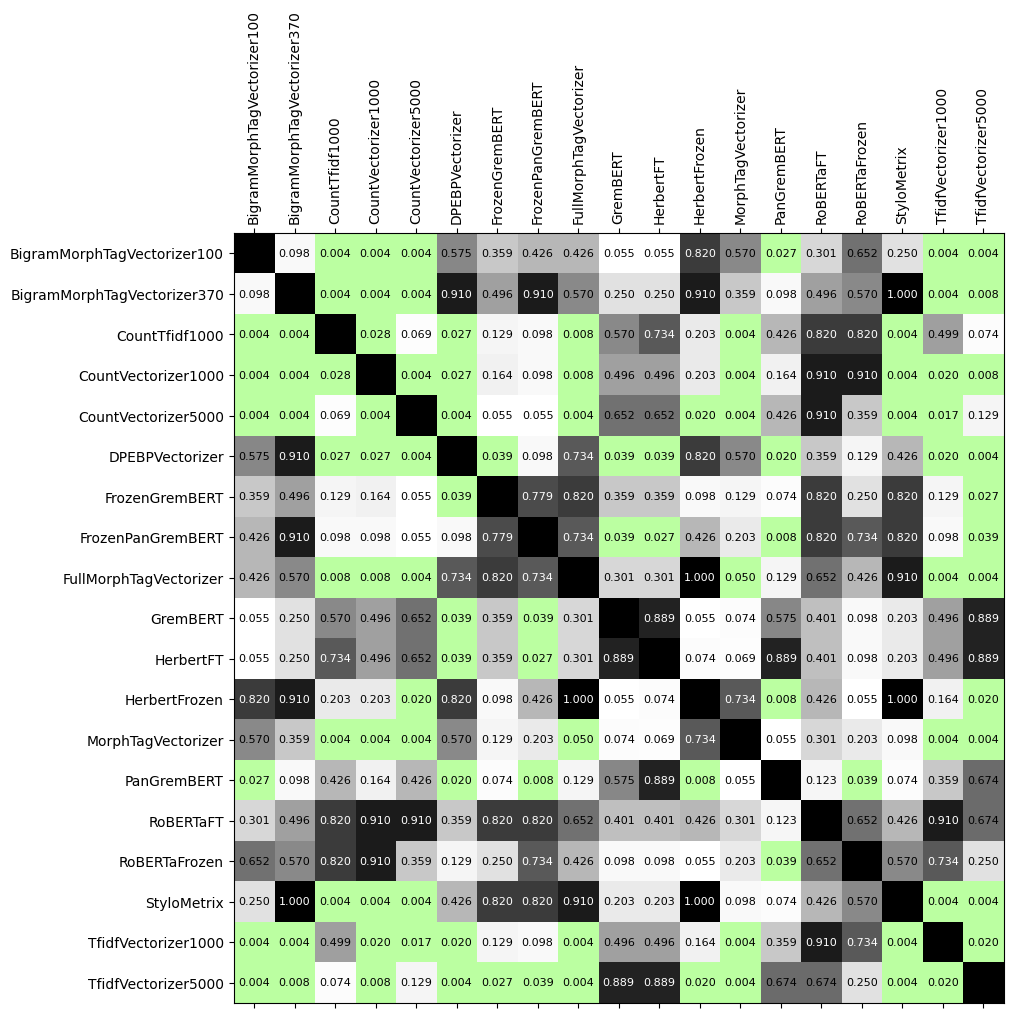

In [127]:
scores, vecs = get_scores(results_df, 'classification', 'f1_score')
ranks = calculate_wilcoxon_signed_rank(scores)
arr = np.ones((len(vecs), len(vecs)))
print(arr.shape)
for i, j, _, p in ranks:
    arr[i, j] = p
    arr[j, i] = p

plot_2d_array(arr, vecs)

d:\HDD\Studia\Mgr\grembedding\venv\lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
d:\HDD\Studia\Mgr\grembedding\venv\lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


(19, 19)


(<Figure size 1500x1000 with 1 Axes>, <Axes: >)

<Figure size 640x480 with 0 Axes>

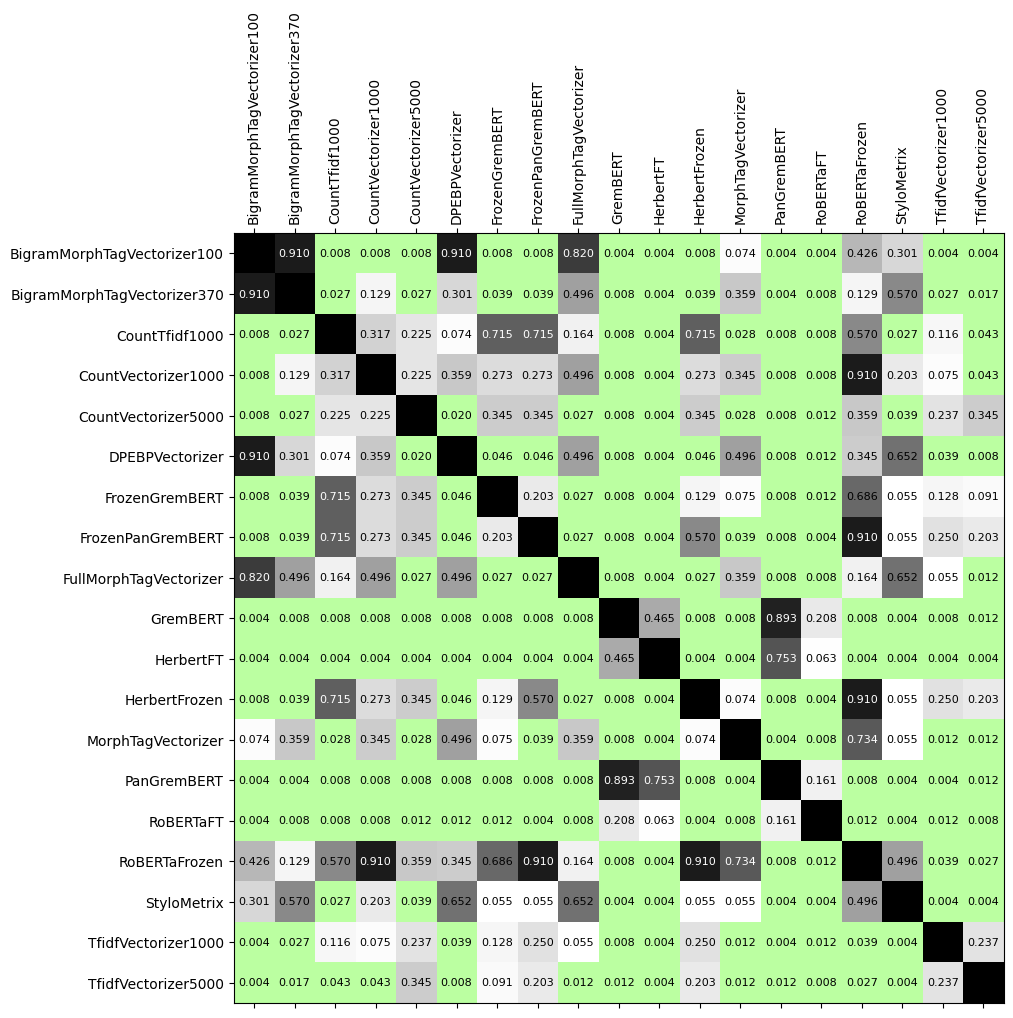

In [129]:
scores, vecs = get_scores(results_df, 'clustering', 'bcubed_f1')
ranks = calculate_wilcoxon_signed_rank(scores)
arr = np.ones((len(vecs), len(vecs)))
print(arr.shape)
for i, j, _, p in ranks:
    arr[i, j] = p
    arr[j, i] = p

plot_2d_array(arr, vecs)

In [107]:
scores[:, 6:8]

array([[0.40709457, 0.40709457],
       [0.67817298, 0.67817298],
       [0.15719346, 0.15719346],
       [0.66671348, 0.66671348],
       [0.66765154, 0.66765154],
       [0.66617869, 0.66617869],
       [0.64028563, 0.64028563],
       [0.91478562, 0.91478562],
       [0.68404103, 0.68404103]])

In [10]:
np.array([
    [1, 2], 
    [3, 4]
])[:, 0]

array([1, 3])